In [2]:
calname = 'snow_cal01'
import glob
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
import ProgressBar as pb
import ipyparallel as par
import time

In [3]:
c = par.Client()

In [4]:
c.ids

[0, 1, 3, 4, 5, 6, 7]

In [5]:
view = c.load_balanced_view()

In [6]:
dat = pd.read_pickle('./data/upper_snowpillow_m.pcl') # load SWE in m
dat.swe *= 1000. # m > mm

In [8]:
dat.index.min()

Timestamp('2007-10-01 00:00:00')

In [9]:
dat.index.max()

Timestamp('2014-09-30 00:00:00')

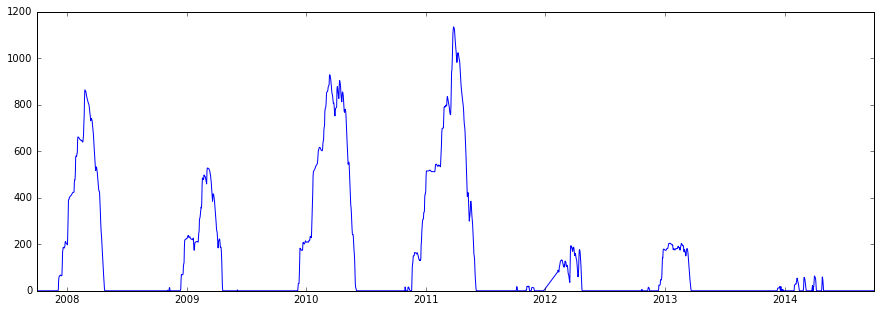

In [10]:
plt.figure(figsize=(15,5))
plt.plot(dat.interpolate())

In [11]:
files = glob.glob('/RHESSys/providence/theo_p301_flux/out/%s/%s_*basin.daily'%(calname,calname))

In [12]:
sims = len(files)

In [47]:
tmp = rut.readRHESSysBasin('/RHESSys/providence/theo_p301_flux/out/%s/%s_0_basin.daily'%(calname,calname))
datmin = tmp.index.min()
datmax = tmp.index.max()

In [48]:
datmin

Timestamp('2008-10-01 00:00:00')

In [49]:
datmax

Timestamp('2011-09-28 00:00:00')

In [16]:
%%px
calname = 'snow_cal01'
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
dat = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/providence/data/upper_snowpillow_m.pcl') # load SWE in cm
dat.swe *= 1000. # m > mm
tmp = rut.readRHESSysBasin('/RHESSys/providence/theo_p301_flux/out/%s/%s_0_basin.daily'%(calname,calname))
datmin = tmp.index.min()
datmax = tmp.index.max()
print datmin
print datmax
dat = dat.loc[datmin:datmax]
#dat.swe.interpolate(inplace=True)
#print tmp.index.max()

[stdout:0] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:1] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:3] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:4] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:5] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:6] 
2008-10-01 00:00:00
2011-09-28 00:00:00
[stdout:7] 
2008-10-01 00:00:00
2011-09-28 00:00:00


In [17]:
def compute_ns(fl):
    idx = int(fl.split('_')[-2])
    tmp = rut.readRHESSysBasin(fl).loc[datmin:datmax] # load the data
    nashsut = round(ofx.nashsut(dat.swe,tmp.snowpack),4)
    pbias = round(ofx.wy_percent_bias(dat.swe,tmp.snowpack),4)
    
    return idx,nashsut,pbias

In [24]:
res = view.map(compute_ns,files)

In [25]:
p = pb.ProgressBar(sims)

In [26]:
while res.ready() == False:
    p.animate_ipython(res.progress)
    time.sleep(2)

[****************100%******************]  19908 of 20000 complete


In [27]:
res.ready()

True

In [28]:
res.progress

20000

In [29]:
idx,nse,pbias = zip(*res.result)

In [31]:
tminrain = np.loadtxt('/RHESSys/providence/theo_p301_flux/scripts/%s_raintemp.txt'%(calname))
tmaxsnow = np.loadtxt('/RHESSys/providence/theo_p301_flux/scripts/%s_snowtemp.txt'%(calname))
msed = np.loadtxt('/RHESSys/providence/theo_p301_flux/scripts/%s_msed.txt'%(calname))
smtc = np.loadtxt('/RHESSys/providence/theo_p301_flux/scripts/%s_smtc.txt'%(calname))
#pmult = np.loadtxt('/RHESSys/jemez/scripts/%s_pmult.txt'%(calname))

In [32]:
#df = pd.DataFrame({'tminrain':tminrain,'tmaxsnow':tmaxsnow,'msed':msed,'smtc':smtc,'pmult':pmult,'idx':np.arange(0,sims)})
df = pd.DataFrame({'tminrain':tminrain,'tmaxsnow':tmaxsnow,'msed':msed,'smtc':smtc,'idx':np.arange(0,sims)})
tmpdf = pd.DataFrame({'nse':nse,'idx':idx,'bias':pbias})

In [33]:
df = pd.merge(df,tmpdf,on='idx')

In [34]:
def compute_metric(df):
    
    bias = 1-df.bias
    nse = df.nse
    
    return np.nanmean([bias,nse])
    

In [35]:
df['metric'] = df.apply(compute_metric,axis=1)

In [36]:
df2 = df.loc[df.metric==df.metric.max()]

In [37]:
df2

,idx,msed,smtc,tmaxsnow,tminrain,bias,nse,metric
9004,9004,-160.2,0.0003,3.37,3.07,0.1257,0.903,0.88865


In [38]:
df.describe()

,idx,msed,smtc,tmaxsnow,tminrain,bias,nse,metric
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,-152.528060,0.099714,0.987193,0.990851,0.543755,0.214172,0.335208
std,5773.647028,84.772086,0.057513,1.722424,1.733614,0.145643,0.225324,0.142196
min,0.000000,-300.000000,0.000100,-2.000000,-2.000000,0.210100,-0.488600,-0.141850
25%,4999.750000,-225.600000,0.049600,-0.500000,-0.510000,0.432500,0.076475,0.234300
50%,9999.500000,-152.900000,0.100100,0.980000,0.970000,0.542550,0.179300,0.319300
75%,14999.250000,-79.000000,0.149200,2.470000,2.500000,0.644600,0.367400,0.426113
max,19999.000000,-5.100000,0.199900,3.990000,3.990000,0.911700,0.651300,0.637800


In [39]:
df2

,idx,msed,smtc,tmaxsnow,tminrain,bias,nse,metric
9004,9004,-160.2,0.0003,3.37,3.07,0.1257,0.903,0.88865


In [40]:
df.loc[df.nse==df.nse.max()]

,idx,msed,smtc,tmaxsnow,tminrain,bias,nse,metric
3847,3847,-47.2,0.0188,1.86,3.55,0.4306,0.6513,0.61035
4435,4435,-46.9,0.1512,2.42,2.31,0.4306,0.6513,0.61035
6549,6549,-47.4,0.1986,2.53,3.97,0.4306,0.6513,0.61035
10041,10041,-47.4,0.1299,2.67,1.71,0.4306,0.6513,0.61035


In [41]:
df2.mean()

idx         17985.0000
msed          -66.8000
smtc            0.0024
tmaxsnow        3.3700
tminrain        2.3500
bias            0.3493
nse             0.6249
metric          0.6378
dtype: float64

In [38]:
df.to_pickle('./data/%s.pcl'%(calname))

In [50]:
tmp = rut.readRHESSysBasin('/RHESSys/providence/theo_p301_flux/out/%s/%s_9004_basin.daily'%(calname,calname)).loc[datmin:datmax]

In [51]:
dat = dat.loc[datmin:datmax]

In [52]:
tmp['accumulated_P'] = tmp.groupby('wateryear').precip.cumsum()

In [53]:
df2

,idx,msed,smtc,tmaxsnow,tminrain,bias,nse,metric
9004,9004,-160.2,0.0003,3.37,3.07,0.1257,0.903,0.88865


(733316.0, 734410.0)

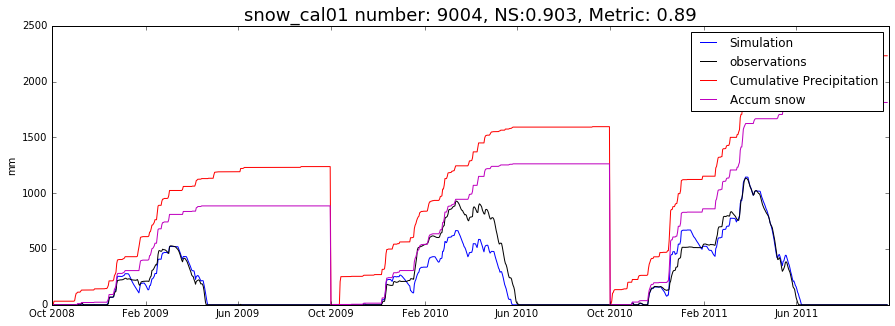

In [55]:
plt.figure(figsize=(15,5))
plt.plot(tmp.index,tmp.snowpack,'-b',label='Simulation')
plt.plot(dat.index,dat.swe,'-k',label='observations')
plt.plot(tmp.index,tmp.accumulated_P,'-r',label='Cumulative Precipitation')
plt.plot(tmp.index,tmp.accumSnowFall,'-m',label='Accum snow')
plt.ylabel('mm')
plt.legend(loc='upper right')
plt.title('%s number: %s, NS:%s, Metric: %s'%(calname,9004,0.903,0.89), fontsize=18)
plt.xlim('2008-10-1','2011-9-30')
#plt.savefig('./figures/%s_bestcal.png'%calname,dpi=300,bbox_inches='tight')

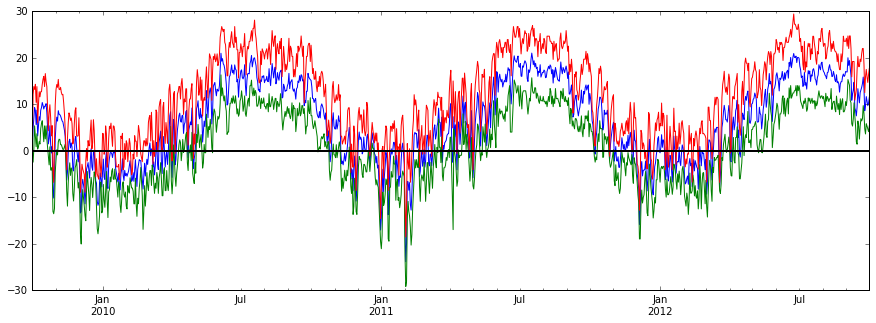

In [47]:
plt.figure(figsize=(15,5))
tmp.tavg.plot()
tmp.tmin.plot()
tmp.tmax.plot()
plt.axhline(0,c='k',lw=2)

In [42]:
tmp.tail()

,basinID,pot_surface_infil,snow_thr,sat_def_z,sat_def,rz_storage,unsat_stor,rz_drainage,unsat_drain,cap,...,LE_snow,Lstar_strat,canopydrip,ga,wateryear,ET,accumPrecip,accumSnowFall,accumET,accumulated_P
2012-09-27,1,30.204983,0,5000,12982.840620,6485.580724,0,0.069875,0,0,...,0,0,0,0,2012,1.928973,5252.121599,1058.665812,676.547142,5252.121599
2012-09-28,1,30.204983,0,5000,12982.770745,6485.510849,0,0.069875,0,0,...,0,0,0,0,2012,1.426992,5282.326582,1058.665812,677.974134,5282.326582
2012-09-29,1,30.204983,0,5000,12982.700871,6485.440974,0,0.069875,0,0,...,0,0,0,0,2012,1.263838,5312.531565,1058.665812,679.237972,5312.531565
2012-09-30,1,30.204983,0,5000,12982.630996,6485.371100,0,0.069875,0,0,...,0,0,0,0,2012,1.832718,5342.736548,1058.665812,681.070690,5342.736548
2012-10-01,1,17.486090,0,5000,12982.561121,6485.301225,0,0.069875,0,0,...,0,0,0,0,2013,2.813123,17.486090,0.000000,2.813123,17.486090


(0, 1)

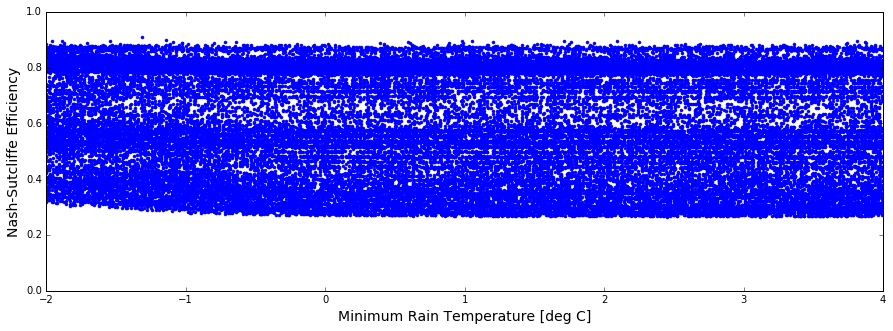

In [34]:
plt.figure(figsize=(15,5))
plt.plot(df.tminrain,df.nse,'.')
plt.xlabel('Minimum Rain Temperature [deg C]', fontsize=14)
plt.ylabel('Nash-Sutcliffe Efficiency', fontsize=14)
plt.ylim(0,1)

(0, 1)

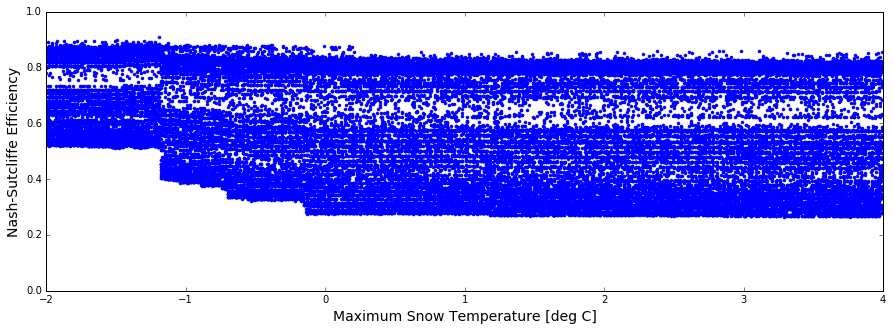

In [35]:
plt.figure(figsize=(15,5))
plt.plot(df.tmaxsnow,df.nse,'.')
plt.xlabel('Maximum Snow Temperature [deg C]', fontsize=14)
plt.ylabel('Nash-Sutcliffe Efficiency', fontsize=14)
plt.ylim(0,1)

(0, 1)

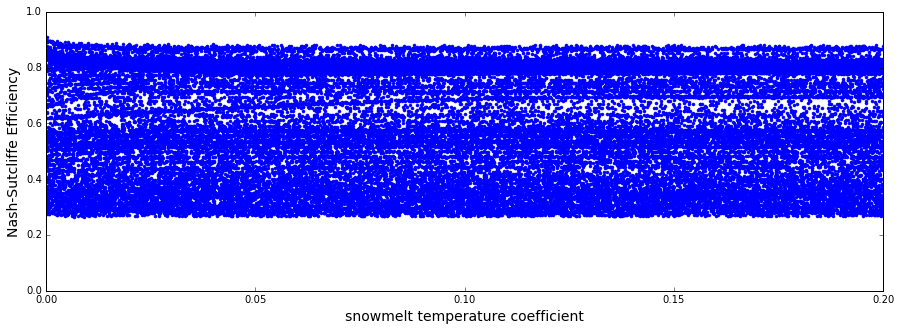

In [36]:
plt.figure(figsize=(15,5))
plt.plot(df.smtc,df.nse,'.')
plt.xlabel('snowmelt temperature coefficient', fontsize=14)
plt.ylabel('Nash-Sutcliffe Efficiency', fontsize=14)
plt.ylim(0,1)

(0, 1)

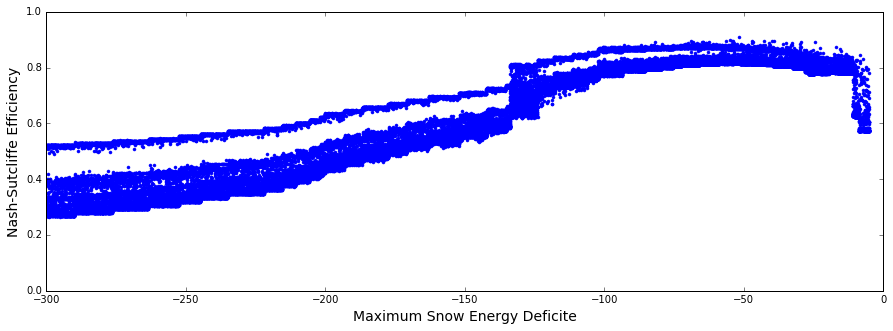

In [37]:
plt.figure(figsize=(15,5))
plt.plot(df.msed,df.nse,'.')
plt.xlabel('Maximum Snow Energy Deficite', fontsize=14)
plt.ylabel('Nash-Sutcliffe Efficiency', fontsize=14)
plt.ylim(0,1)

In [33]:
ofx.nashsut(dat.swe,tmp.snowpack)

0.31001657027814311

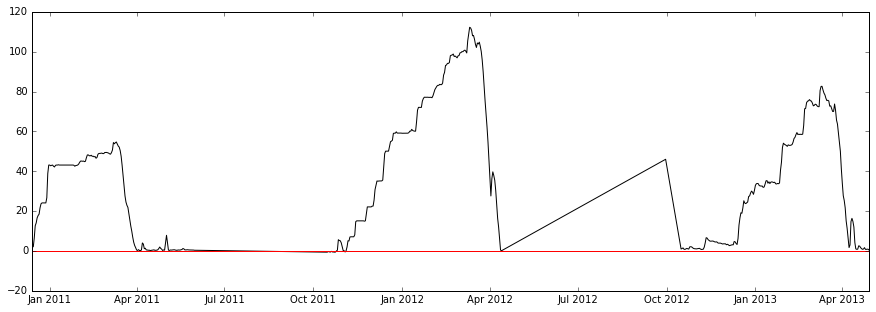

In [34]:
plt.figure(figsize=(15,5))
plt.plot(dat.index,dat.swe.interpolate('linear'),'-k',label='observations')
plt.axhline(0,c='r')